In [1]:
# Import libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.svm as svm
import sklearn.pipeline as spl
import sklearn.kernel_ridge as skr
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.neural_network as snn
import sklearn.metrics as sme
import sklearn.decomposition as sdc
import sklearn.cross_decomposition as skd
import sklearn.ensemble as ske
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
import numpy as np
from IPython.display import HTML
import util

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [3]:
# Maybe y should also be scaled? 
#     Performed poorly using Standard and MinMax scalers. Trying with LOOCV to see if predictions stabilize.
#     Does not appear to stabilize predictions with LOOCV (using StandardScaler())
# Perhaps a transform would be more effective, or scaling implemented with consistent cross-validation
# Different scaling methods? 
#     This seems most important for noise-sensitive models like LARS. All other use StandardScaler()
# Transformers?
# Model-specific scaling methods?
#     Yes, see above
# Common cross-validation function?
#     Use built-in functions wherever possible and `utils.gridsearch_pickparams()` elsewhere
# Quantile loss
# RANSAC
# Data augmentation? (Mixup)
# Data generation? (SMOGN)

In [4]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595)
ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,:,:]
K_all_c = K_all[c_cases_idx,:,:]
R_all_c = R_all[c_cases_idx,:,:]
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]
per_change = post_imp

In [5]:
X_train,X_test,y_train,y_test,train_index,test_index = util.set_split(X_all_c,per_change,1,5/len(X_all_c))
# Cross validation
cvn = 10
# Choose scaling
X0_ss,scaler_ss,X_test_ss = util.model_scale(skp.StandardScaler(),
                                             X_train,train_index,X_test,test_index,pre_updrs_off)
X0_mm,scaler_mm,X_test_mm = util.model_scale(skp.MinMaxScaler(),
                                             X_train,train_index,X_test,test_index,pre_updrs_off)
X0_ma,scaler_ma,X_test_ma = util.model_scale(skp.MaxAbsScaler(),
                                             X_train,train_index,X_test,test_index,pre_updrs_off)
X0_rs,scaler_rs,X_test_rs = util.model_scale(skp.RobustScaler(),
                                             X_train,train_index,X_test,test_index,pre_updrs_off)


In [6]:
scoring = 'r2'
print(y_test)
print(y_test.mean())
print(y_train)
print(y_train.mean())

[0.5        0.55932203 0.74545455 0.74418605 0.55555556]
0.6209036362840068
[0.67241379 0.74358974 0.55555556 0.96774194 0.87301587 0.19444444
 0.42857143 0.83928571 0.68656716 0.7037037  0.52272727 0.95238095
 0.73684211 0.59259259 0.66153846 0.90909091 0.46774194 0.65517241
 0.84615385 0.88311688 0.66666667 0.5        0.7        0.08571429
 0.35897436 0.825      0.93939394 0.14705882 0.30232558 0.87878788
 0.80357143 0.51724138 0.69135802 0.53125    0.85294118 0.48571429
 0.66666667 0.83076923 0.88888889 0.1875     0.26086957 0.48333333]
0.6308636248135558


In [7]:
alphas = np.logspace(-9,-1,10)

In [8]:
lr = slm.LinearRegression()
est_lr = lr.fit(X0_ss,y_train)
results_lr = est_lr.predict(X_test_ss.reshape([X_test_mm.shape[0],
                                           X_test_mm.shape[1]*X_test_mm.shape[2]]))
print(results_lr)

[0.61369232 0.37272684 1.06917158 0.88678681 0.65288307]


In [9]:
br_grid = {'alpha_1': alphas[-5:-4], 'alpha_2': alphas[-5:-4]}

best_params = util.gridsearch_pickparams(slm.BayesianRidge(),cvn,
                                         br_grid,scaler_ss,X_train,
                                         train_index,X_test,test_index,pre_updrs_off,y_train.ravel(),scoring,8)
br = slm.BayesianRidge(alpha_1=best_params['alpha_1'],alpha_2=best_params['alpha_2'])
br.fit(X0_ss, y_train)
results_br = np.asarray(br.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))).ravel()
print(results_br)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[0.61343043 0.37280623 1.0690812  0.88652602 0.65283792]


In [10]:
mlp_grid = {'hidden_layer_sizes': [(X_train.shape[1],X_train.shape[2])],
          'activation': ['relu'],
          'alpha': alphas,
          'epsilon': [1e0],
          'solver': ['adam'],
          'max_iter':[5000]}

best_params = util.gridsearch_pickparams(snn.MLPRegressor(),
                                         cvn,mlp_grid,scaler_ss,X_train,
                                         train_index,X_test,test_index,pre_updrs_off,y_train,scoring,-1)

mlp = snn.MLPRegressor(hidden_layer_sizes=best_params["hidden_layer_sizes"], 
                        activation=best_params["activation"],
                        solver=best_params["solver"],
                        alpha=best_params['alpha'],
                        epsilon=best_params["epsilon"],
                        max_iter=5000, 
                        n_iter_no_change=500, 
                        verbose=True,
                        early_stopping=True,
                        random_state=1,
                        batch_size=len(X0_ss)//cvn)

mlp.fit(X0_ss,y_train)
results_mlp = mlp.predict(X_test_ss.reshape([X_test_mm.shape[0],
                                           X_test_mm.shape[1]*X_test_mm.shape[2]]))

print(results_mlp)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Iteration 1, loss = 0.22916993
Validation score: -7.354859
Iteration 2, loss = 0.22610111
Validation score: -7.244933
Iteration 3, loss = 0.22150595
Validation score: -7.104387
Iteration 4, loss = 0.21623126
Validation score: -6.941387
Iteration 5, loss = 0.21063642
Validation score: -6.769021
Iteration 6, loss = 0.20485710
Validation score: -6.591441
Iteration 7, loss = 0.19849663
Validation score: -6.401006
Iteration 8, loss = 0.19205160
Validation score: -6.172957
Iteration 9, loss = 0.18503676
Validation score: -5.968164
Iteration 10, loss = 0.17834077
Validation score: -5.758490
Iteration 11, loss = 0.17138393
Validation score: -5.548634
Iteration 12, loss = 0.16475234
Validation score: -5.344850
Iteration 13, loss = 0.15803191
Validation score: -5.109896
Iteration 14, loss = 0.15136214
Validation score: -4.882353
Iteration 15, loss = 0.14418885
Validation score: -4.682359
Iteration 16, loss = 0.13783932
Validation sco

In [11]:
lasso = slm.LassoCV(
    alphas=alphas,
    cv=cvn, 
    verbose=True,
    random_state=1,
    max_iter=1000,
    tol=1e-2,
    n_jobs=-1)

est_ls = lasso.fit(X0_ss,y_train)
results_ls = est_ls.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))
print(results_ls)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
......................................................................[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    1.0s remaining:    4.1s
...........................

[0.641205   0.60683761 0.64444677 0.63769112 0.61773286]


...[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.2s finished


In [12]:
ridge = slm.RidgeCV(
    alphas=alphas,
    scoring=scoring,
    cv=cvn)

est_rr = ridge.fit(X0_ss,y_train)
results_rr = est_rr.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))
print(results_rr)

[0.61342974 0.37279232 1.06935855 0.88671296 0.65280129]


In [33]:
lars = slm.LarsCV(
    cv=cvn, 
    max_iter=1000,
    max_n_alphas=1000,
    verbose=True,
    normalize=False,
    eps=np.finfo(float).eps,
    n_jobs=-1)

est_lars = lars.fit(X0_rs,y_train)
results_lars = est_lars.predict(X_test_rs.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))
print(results_lars)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    3.6s remaining:   14.3s


[0.63599928 0.47800835 0.63599925 0.63599944 0.63599927]


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.8s finished


In [14]:
krr_grid = {'kernel': ['linear','rbf'],
          'alpha': [alphas]}

best_params = util.gridsearch_pickparams(skr.KernelRidge(),
                                         cvn,krr_grid,scaler_ss,X_train,train_index,
                                         X_test,test_index,pre_updrs_off,y_train,scoring,-1)
krr = skr.KernelRidge(kernel=best_params['kernel'],alpha=best_params['alpha'])
krr.fit(X0_ss, y_train)
results_krr = krr.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))
print(results_krr)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[0.43950406 0.17270831 0.52380773 0.64079946 0.64339974]


In [15]:
gsc = slm.ElasticNetCV(
    alphas=alphas,
    cv=cvn, 
    max_iter=10000,
    verbose=True,
    n_jobs=-1)

est_en = gsc.fit(X0_ss,y_train)
results_en = est_en.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))
print(results_en)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
.................................[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    1.9s remaining:    7.8s
...................................................................[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished


[0.59660805 0.46191708 0.84977107 0.7642301  0.65862843]


In [16]:
pls_grid = {'n_components': np.flip(np.arange(5,int(len(X_train)))),
            'scale': [True,False]}

best_params = util.gridsearch_pickparams(skd.PLSRegression(),cvn,
                                         pls_grid,scaler_ss,X_train,
                                         train_index,X_test,test_index,pre_updrs_off,y_train,scoring,-1)
pls = skd.PLSRegression(n_components=best_params['n_components'],scale=best_params['scale'],max_iter=10000)
pls.fit(X0_ss, y_train)
results_pls = (pls.predict(X_test_ss.reshape([X_test_rs.shape[0],
                                           X_test_rs.shape[1]*X_test_rs.shape[2]]))).ravel()

print(results_pls)

Fitting 10 folds for each of 74 candidates, totalling 740 fits
[0.60813895 0.3727464  1.0665074  0.88531537 0.65398654]


In [17]:
pcr = spl.make_pipeline(sdc.PCA(),slm.LinearRegression())
pcr.fit(X0_ss, y_train)
results_pcr = np.asarray(pcr.predict(X_test_ss.reshape([X_test_rs.shape[0],
                                           X_test_rs.shape[1]*X_test_rs.shape[2]]))).ravel()
print(results_pcr)

[0.61323187 0.37298244 1.0697113  0.88647109 0.65259831]


In [18]:
omp = slm.OrthogonalMatchingPursuitCV(normalize=False,cv=cvn,max_iter=len(X_train)//2)
omp.fit(X0_ss, y_train)
results_omp = np.asarray(omp.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))).ravel()
print(results_omp)

[0.72327191 0.44806773 0.66742821 0.63995748 0.52598783]


In [19]:
rsr = slm.RANSACRegressor(random_state=1,min_samples=len(X0_ss)).fit(X0_ss, y_train)
results_rsr = rsr.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]])).ravel()
print(results_rsr)

[0.61369232 0.37272684 1.06917158 0.88678681 0.65288307]


In [20]:
# Very slow on leave one out
# ard_grid = {'alpha_1': alphas[-5:-4], 'alpha_2': alphas[-5:-4], 'lambda_1': alphas[-5:-4], 'lambda_2': alphas[-5:-4]}
# best_params = util.gridsearch_pickparams(slm.ARDRegression(),cvn,
#                                          ard_grid,scaler_ss,X_train,
#                                          train_index,X_test,test_index,pre_updrs_off,y_train,scoring,8)
# ard = slm.ARDRegression(alpha_1=best_params['alpha_1'],alpha_2=best_params['alpha_2'],
#                        lambda_1=best_params['lambda_1'],lambda_2=best_params['lambda_2'])
# ard.fit(X0_ss,y_train)
# results_ard = np.asarray(ard.predict(X_test_ss.reshape([X_test_ss.shape[0],
#                                            X_test_ss.shape[1]*X_test_ss.shape[2]]))).ravel()

In [21]:

svr_grid = {'kernel': ['linear','rbf'],
          'epsilon': [1e-1,1.5e-1,2.5e-1]}
best_params = util.gridsearch_pickparams(svm.SVR(),
                                         cvn,svr_grid,scaler_ss,X_train,
                                         train_index,X_test,test_index,pre_updrs_off,y_train,scoring,-1)
svr = svm.SVR(kernel=best_params['kernel'],epsilon=best_params['epsilon'])
svr.fit(X0_ss, y_train)
results_svr = np.asarray(svr.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))).ravel()
print(results_svr)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[0.58790128 0.59152017 0.74523036 0.70831848 0.62494158]


In [22]:
gbr_grid = {'max_depth':[3,6,9,12]}
best_params = util.gridsearch_pickparams(ske.GradientBoostingRegressor(random_state=1),cvn,
                                         gbr_grid,scaler_ss,X_train,
                                         train_index,X_test,test_index,pre_updrs_off,y_train,scoring,8)
gbr = ske.GradientBoostingRegressor(random_state=1,max_depth=best_params['max_depth'],n_estimators=X0_ss.shape[1])
gbr.fit(X0_ss, y_train)
results_gbr = np.asarray(gbr.predict(X_test_ss.reshape([X_test_ss.shape[0],
                                           X_test_ss.shape[1]*X_test_ss.shape[2]]))).ravel()

Fitting 10 folds for each of 4 candidates, totalling 40 fits


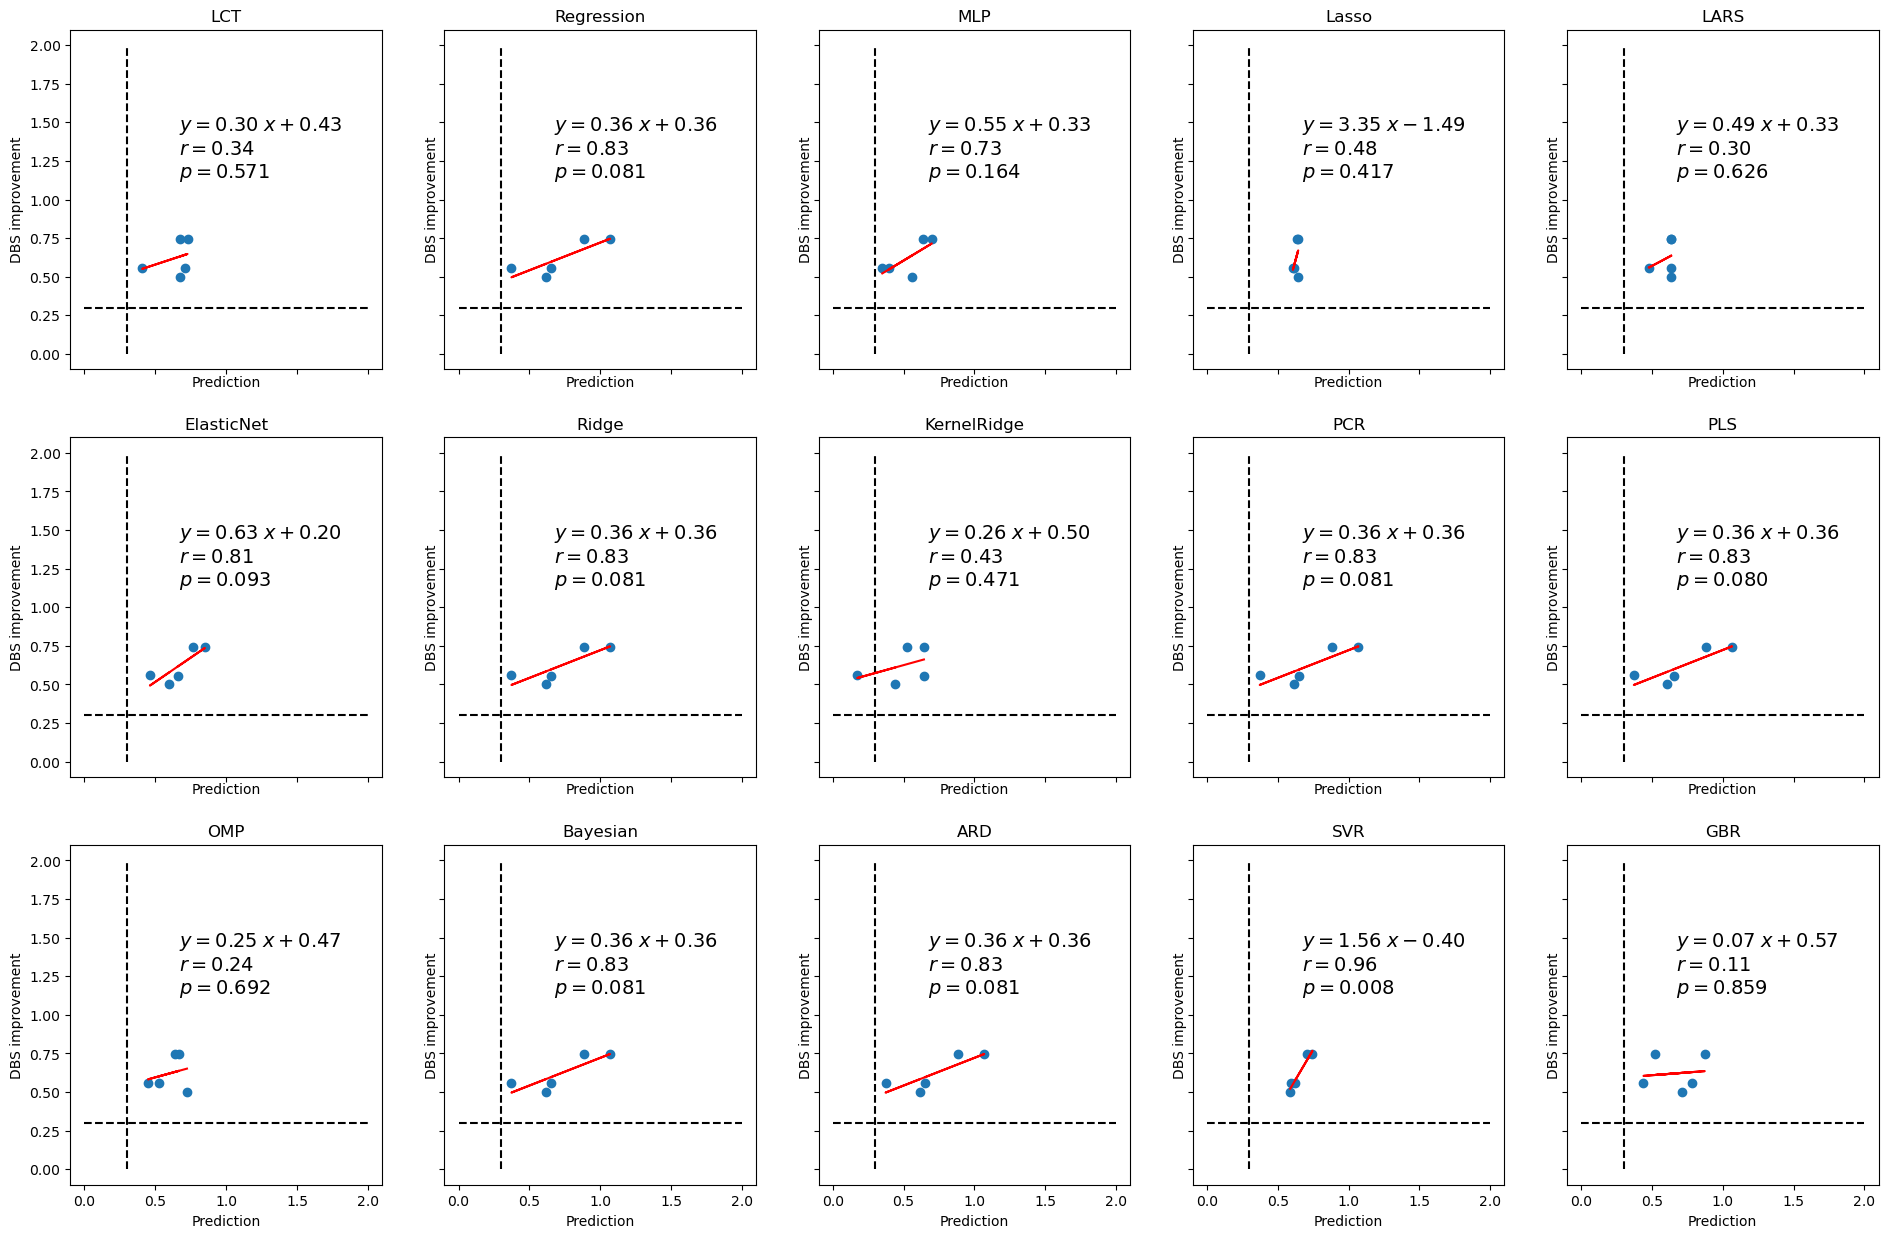

In [34]:
util.eval_prediction(np.vstack((pre_imp[test_index],
                               results_lr.ravel(),
                               results_mlp,
                               results_ls,
                               results_lars,
                               results_en,
                               results_rr.ravel(),
                               results_krr.ravel(),
                               results_pcr,
                               results_pls,
                               results_omp,
                               results_br,
                               results_rsr,
                               results_svr,
                               results_gbr)),
                               y_test,
                               ['LCT','Regression','MLP','Lasso','LARS',
                                'ElasticNet','Ridge','KernelRidge','PCR',
                                'PLS','OMP','Bayesian','ARD','SVR','GBR'],(70,5))
#plt.ylim([0,2])

In [24]:
# np.save('X_test.npy',X_test)
# np.save('X_train.npy',X_train)
# np.save('y_test.npy',y_test)
# np.save('y_train.npy',y_train)
# np.save('test_index.npy',test_index)
# np.save('train_index.npy',train_index)